Loading engineered pipeline data...
✅ Data loaded successfully!
Training Isolation Forest model...

Model Evaluation:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      2795
           1       0.00      0.00      0.00         0

    accuracy                           0.97      2795
   macro avg       0.50      0.48      0.49      2795
weighted avg       1.00      0.97      0.98      2795



/home/kiddomendes/Documents/GitHub/VUT/energy_theft_and_oil_leak/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/kiddomendes/Documents/GitHub/VUT/energy_theft_and_oil_leak/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/kiddomendes/Documents/GitHub/VUT/energy_theft_and_oil_leak/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_divi

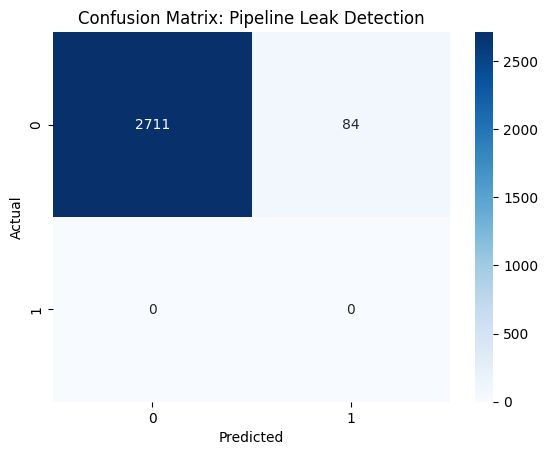

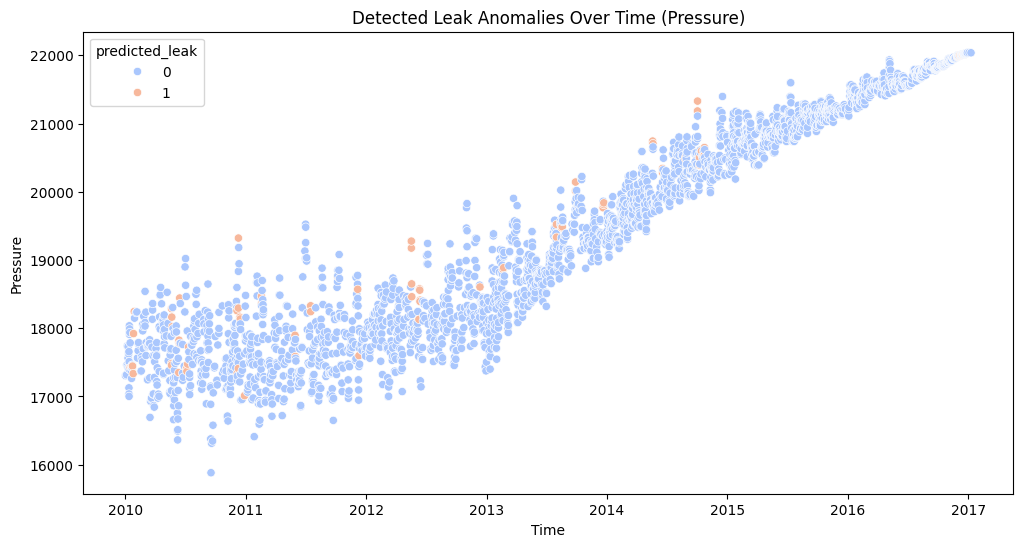


💾 Model saved to: /var/home/kiddomendes/Documents/GitHub/VUT/energy_theft_and_oil_leak/data/pipeline_model.joblib
💾 Scaler saved to: /var/home/kiddomendes/Documents/GitHub/VUT/energy_theft_and_oil_leak/data/pipeline_scaler.joblib


In [1]:
# 04_model_pipeline_leak.ipynb
# AI Model for Pipeline Leak Detection

# ---------------------------------------------------
# 1️⃣ Import Libraries
# ---------------------------------------------------
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib

# ---------------------------------------------------
# 2️⃣ Load Engineered Data
# ---------------------------------------------------
DATA_DIR = Path.cwd().parent / 'data'
pipeline_path = DATA_DIR / 'pipeline_features.csv'

print("Loading engineered pipeline data...")
pipeline_df = pd.read_csv(pipeline_path)
print("✅ Data loaded successfully!")

# Detect time column
date_col = [col for col in pipeline_df.columns if 'time' in col.lower() or 'date' in col.lower()][0]
pipeline_df[date_col] = pd.to_datetime(pipeline_df[date_col])

# ---------------------------------------------------
# 3️⃣ Prepare Data
# ---------------------------------------------------
features = ['flow_mean_5', 'flow_std_5', 'pressure_mean_5', 'pressure_std_5', 
            'flow_change', 'pressure_change', 'flow_pressure_corr']
X = pipeline_df[features]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------------------------------------
# 4️⃣ Train Isolation Forest
# ---------------------------------------------------
print("Training Isolation Forest model...")
iso_forest = IsolationForest(contamination=0.03, random_state=42)
pipeline_df['anomaly_score'] = iso_forest.fit_predict(X_scaled)
pipeline_df['predicted_leak'] = pipeline_df['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)

# ---------------------------------------------------
# 5️⃣ Evaluate (using potential_leak flag as reference)
# ---------------------------------------------------
if 'potential_leak' in pipeline_df.columns:
    print("\nModel Evaluation:")
    print(classification_report(pipeline_df['potential_leak'], pipeline_df['predicted_leak']))
    cm = confusion_matrix(pipeline_df['potential_leak'], pipeline_df['predicted_leak'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix: Pipeline Leak Detection')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# ---------------------------------------------------
# 6️⃣ Visualize Detected Leaks
# ---------------------------------------------------
plt.figure(figsize=(12, 6))
sns.scatterplot(x=pipeline_df[date_col], y=pipeline_df['pressure_mean_5'], hue=pipeline_df['predicted_leak'], palette='coolwarm')
plt.title('Detected Leak Anomalies Over Time (Pressure)')
plt.xlabel('Time')
plt.ylabel('Pressure')
plt.show()

# ---------------------------------------------------
# 7️⃣ Save Model and Scaler
# ---------------------------------------------------
model_path = DATA_DIR / 'pipeline_model.joblib'
scaler_path = DATA_DIR / 'pipeline_scaler.joblib'
joblib.dump(iso_forest, model_path)
joblib.dump(scaler, scaler_path)

print(f"\n💾 Model saved to: {model_path}")
print(f"💾 Scaler saved to: {scaler_path}")
